In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# K-Nearest Neighbors (kNN)

$k$-Nearest neighbors is one of the simplest predictive models there is. 
The only things it requires are:
   1. Some notion of distance.
   2. An assumption that points that are close to one another are similar.

Let's say we've picked a number $k$ (like 3 or 5).
Then, when we want to classify some new data point, we find the $k$ nearest labeled points and let them vote on the new ouput.
To do this, we'll need a function that counts votes. In case of a tie, we have several options:
   1. Pick one of the winners at random.
   2. Weight the votes by distance and pick the weighted winner.
   3. Reduce k until we find a unique winner.
   
We'll implement the third:

In [1]:
from collections import Counter

def majority_vote(labels) :
    
    """Assumes that labels are ordered from nearest to farthest"""
    vote_counts = Counter(labels) #count votes
    winner,winner_count = vote_counts.most_common(1)[0] 
    num_winners = sum(np.array(list(vote_counts.values()))==winner_count)
    #num_winners = len([1 for count in vote_counts.values() if count == winner_count]) # number of winners
    if num_winners == 1:
        return winner
    else:
        return majority_vote(labels[:-1]) #try again without the farthest

In [5]:
Counter(['a','b','c','b','a']).most_common()[0][0]

'a'

Let's create the classifier

In [6]:
def knn_classifier(k,points,labels,new_point):
    'knn_classifier classifies new_point'
    
    #order the labeled points from nearest to farthest
    distances = np.linalg.norm(points-new_point, axis=1)
    idx = np.argsort(distances) #Returns the indices that would sort distances. 
    return majority_vote(labels[idx[0:k]])

# Example: Classification of handwritten digits

In [7]:
'Obtain the MNist dataset'
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
X,y=mnist['data'],mnist['target']
X.shape

(70000, 784)

In [8]:
'MNIST Dataset is too large for knn. We will use the first 5000 digits'
X,y = X[:5000],y[:5000]

(-0.5, 27.5, 27.5, -0.5)

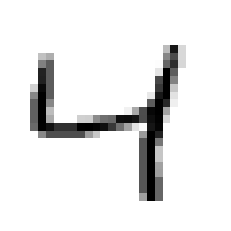

In [9]:
digit = X[2,:].reshape(28,28) # each row is a 28 by 28 image
plt.imshow(digit,cmap='binary')
plt.axis('off')

In [10]:
y[2]

'4'

In [11]:
'split dataset into training, validation and test'
X_train,y_train = X[:3000],y[:3000] #it is used to train the model
X_val,y_val = X[3000:4000], y[3000:4000] #it is used to choose the best parameters (k)
X_test,y_test = X[4000:],y[4000:] #it is used to test the model

In [13]:
'initialize y_test_predicted as an empty list'
y_val_predicted = []

In [14]:
k = 10 #number of neighbors
for i in range(len(y_val)):
    new_point = X_val[i,:]
    y_val_predicted.append(knn_classifier(k, X_train, y_train, new_point))

In [15]:
y_val_predicted = np.array(y_val_predicted)
y_val_predicted.shape, y_val.shape

((1000,), (1000,))

In [16]:
'confusion matrix'
C = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        C[i,j] = sum(y_val_predicted[y_val==str(i)]==str(j))
C

array([[ 92.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.],
       [  0., 104.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.],
       [  2.,   6.,  87.,   0.,   0.,   0.,   0.,   1.,   2.,   0.],
       [  0.,   3.,   1.,  88.,   2.,   2.,   0.,   1.,   0.,   0.],
       [  0.,   3.,   0.,   0.,  96.,   0.,   1.,   0.,   0.,   5.],
       [  1.,   2.,   0.,   0.,   0.,  70.,   1.,   1.,   0.,   1.],
       [  3.,   1.,   0.,   0.,   0.,   0.,  95.,   0.,   0.,   0.],
       [  0.,   4.,   0.,   0.,   1.,   0.,   0.,  98.,   0.,   1.],
       [  2.,   6.,   0.,   7.,   2.,   1.,   0.,   2.,  88.,   4.],
       [  1.,   2.,   0.,   1.,   2.,   0.,   1.,   5.,   0.,  98.]])

In [17]:
'percentage of incorrect classifications'
num_incorrect = sum(y_val != y_val_predicted)
num_incorrect/len(y_val)

0.084

# Choosing k (the number of neighbors)

In [27]:
'classify the validation set using different values for k'
pct_incorrect = np.zeros((20,1))
k_list = [k+1 for k in range(20)] 
for k in k_list: #k = 1,2,...,20
    
    'classify validation digits'
    y_val_predicted = [] #initialize y_val_predicted
    for i in range(len(y_val)):
        new_point = X_val[i,:]
        y_val_predicted.append(knn_classifier(k, X_train, y_train, new_point))
        
    'percentage of incorrect classifications'
    num_incorrect = sum(y_val != y_val_predicted)
    pct_incorrect[k-1] = 100*num_incorrect/len(y_val)

Text(0.5, 1.0, 'Percentage of incorrect classifications')

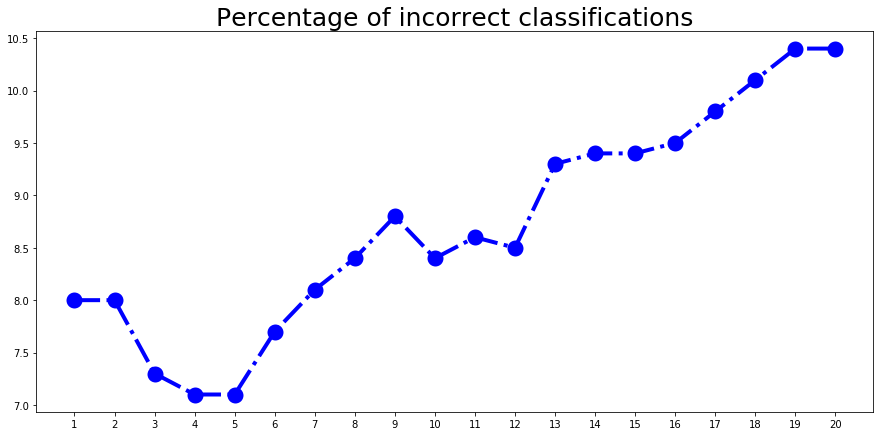

In [28]:
plt.figure(figsize=(15,7))
plt.plot(k_list, pct_incorrect,'bo-.',markeredgewidth=10,linewidth=4)
plt.xticks(k_list)
plt.title('Percentage of incorrect classifications',fontsize=25)

# Testing knn-classifier

In [24]:
'initialize y_test_predicted as an empty list'
y_test_predicted = []

'use knn classifier to classify the test digits'
k = 2 #optimal k; from previous section
for i in range(len(y_test)):
    new_point = X_test[i,:]
    y_test_predicted.append(knn_classifier(k, X_train, y_train, new_point))
y_test_predicted = np.array(y_test_predicted)

In [25]:
'confusion matrix'
C = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        C[i,j] = sum(y_test_predicted[y_test==str(i)]==str(j))

In [26]:
'percentage of correct classifications'
num_correct = sum(y_test == y_test_predicted)
100*num_correct/len(y_test)

92.7